In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import precision_score, recall_score, auc
import sys

sys.path.insert(0, '../')
from Config import get_data_dir

def get_map(preds, num = 51):
    orig = preds['orig']
    
    thresholds = np.linspace(start = 0.0, stop = 1.0, num = num, endpoint = True)
    
    with open('./2-Models/Categories.json', 'r') as f:
        cats = json.load(f)
    
    ap = []
    for cat in cats:
        index = cat['id']

        y_hat = [orig[x][0][index] for x in list(orig)]
        y_true = [orig[x][1][index] for x in list(orig)]

        p = []
        r = []
        for t in thresholds:
            y_hat_t = 1.0 * (y_hat >= t)

            v = precision_score(y_true, y_hat_t, zero_division = 1.0)
            p.append(v)

            v = recall_score(y_true, y_hat_t, zero_division = 0.0)
            r.append(v)

        ap.append(auc(r, p))
    
    return np.mean(ap)

def get_metrics(pair, preds, threshold = 0.5, min_samples = 25):
    
    main = pair.split('-')[0]
    spurious = pair.split('-')[1]
    
    # Get the index that we care about for this pair
    with open('./2-Models/Categories.json', 'r') as f:
        cats = json.load(f)
        
    for cat in cats:
        if cat['name'] == main.replace('+', ' '):
            index = int(cat['id'])
            break

    # Get the splits for this object pair
    with open('{}/val/splits/{}-{}.json'.format(get_data_dir(), main, spurious), 'r') as f:
        splits = json.load(f)
        
    # Calculate the accuracy on each split
    acc = {}
    for name in splits:
        split = splits[name]
        n = len(split)

        hat = np.zeros((n))
        true = np.zeros((n))
        for i, id in enumerate(split):
            hat[i] = preds['orig'][id][0][index]
            true[i] = preds['orig'][id][1][index]
            
        if n < min_samples:
            hat = preds['{}-{}'.format(pair, name)][0][:, index]
            true = preds['{}-{}'.format(pair, name)][1]

        acc[name] = np.mean(1.0 * (hat >= threshold) == true)

    # Compute the metrics on the 'balanced' distribution
    # -  We keep P(Main) from the original dataset
    # -  We then construct a distribution where Spurious is independent from Main
    # -  We use either P(Spurious) = 1/2 while doing this
    total = len(splits['both']) + len(splits['just_main']) + len(splits['just_spurious']) + len(splits['neither'])
    p_main = (len(splits['both']) + len(splits['just_main'])) / total
    p_spurious = 0.5
    
    both = acc['both']
    just_main = acc['just_main']
    just_spurious = acc['just_spurious']
    neither = acc['neither']
    
    tp = p_main * (p_spurious * both + (1 - p_spurious) * just_main)
    fp = (1 - p_main) * (p_spurious * (1 - just_spurious)  + (1 - p_spurious) * (1 -  neither))    
    
    if tp == 0.0:
        precision = 1.0
    else:
        precision = tp / (tp + fp + 1e-16)
        
    recall = p_spurious * both + (1 - p_spurious) * just_main

    # Setup the output
    out = {}
    for name in acc:
        out[name] = acc[name]
    out['b-precision'] = precision
    out['b-recall'] = recall
    out['r-gap'] = abs(both - just_main)
    out['h-gap'] = abs(neither - just_spurious)
    return out

def get_curves(pair, preds, num = 101):
    thresholds = list(np.linspace(start = 0.0, stop = 1.0, num = num, endpoint = True))
    p = []
    r = []
    r_gap = []
    h_gap = []
    for t in thresholds:
        metrics = get_metrics(pair, preds, threshold = t)
        p.append(metrics['b-precision'])
        r.append(metrics['b-recall'])
        r_gap.append(metrics['r-gap'])
        h_gap.append(metrics['h-gap'])
    return p, r, r_gap, h_gap, thresholds

def interpolate(x, y, x_t):
    y_rev = list(reversed(list(y)))
    x_rev = list(reversed(list(x)))
    return np.interp(x_t, x_rev, y_rev)

def average_same_x(x, y_list):
    n = len(x)
    d = len(y_list)
    out = []
    for i in range(n):
        v = 0.0
        for j in range(d):
            v += y_list[j][i]
        v /= d
        out.append(v)
    return out

In [2]:
modes = {'baseline-transfer-ptune': 'Baseline', 'SPIRE': 'SPIRE', 'fs-tune-pbase': 'FS'}
trials = [0,1,2,3,4,5,6,7]

In [3]:
print('MAP')
for mode in modes:

    agg = []
    for trial in trials:

        with open('./2-Models/Models/{}/trial{}/predictions.pkl'.format(mode, trial), 'rb') as f:
            preds = pickle.load(f)
        
        agg.append(get_map(preds))
        
    print(modes[mode], np.round(np.mean(agg), 3), np.round(np.std(agg), 3))


MAP
Baseline 0.608 0.012
SPIRE 0.599 0.011
FS 0.607 0.012


cell+phone-person


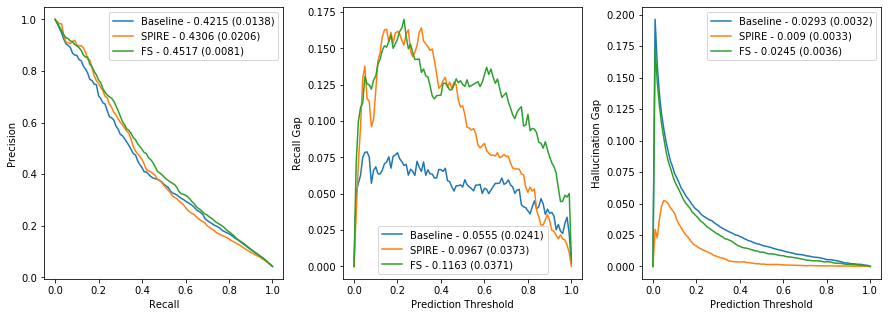

handbag-person


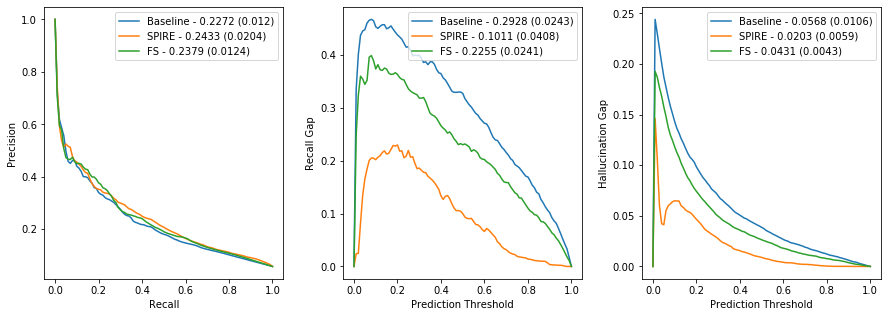

bench-elephant


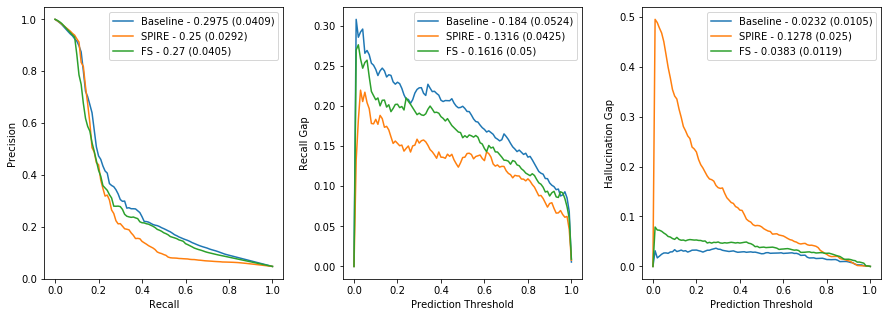

truck-airplane


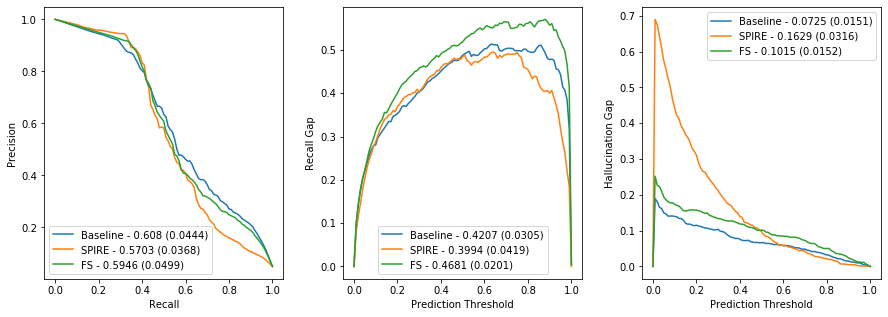

sandwich-dining+table


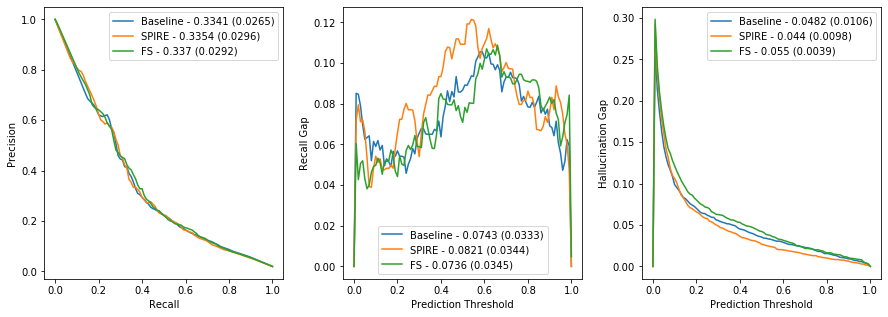

dog-sheep


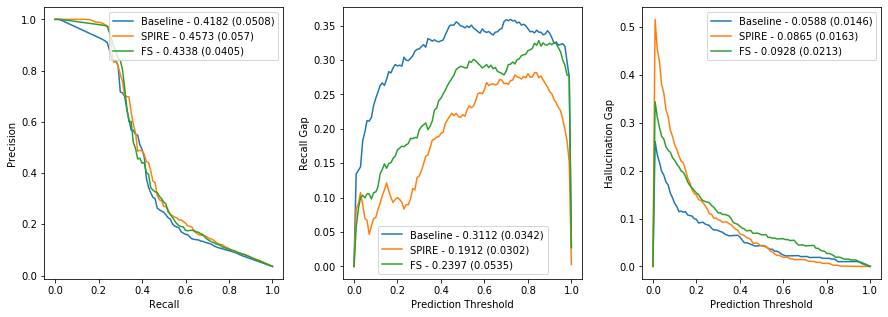

donut-person


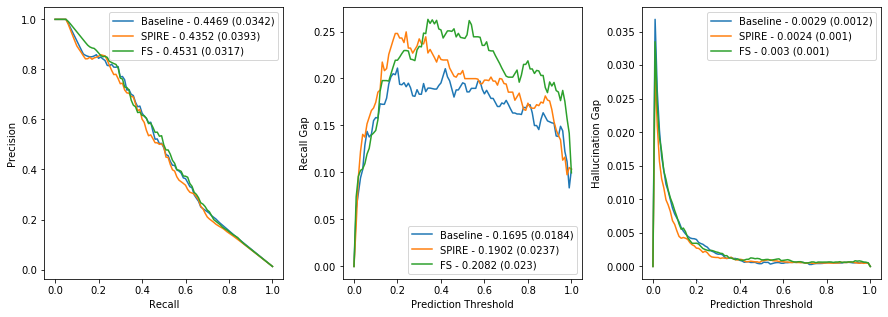

tie-cat


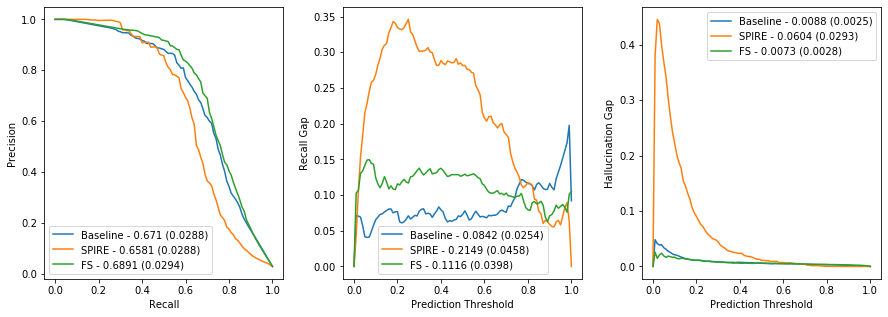

tie-person


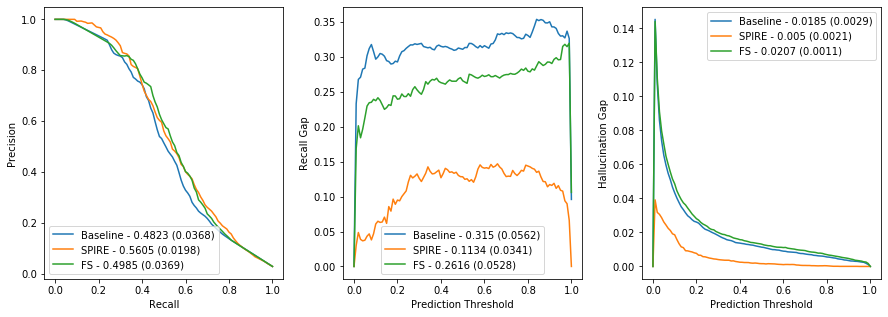

couch-person


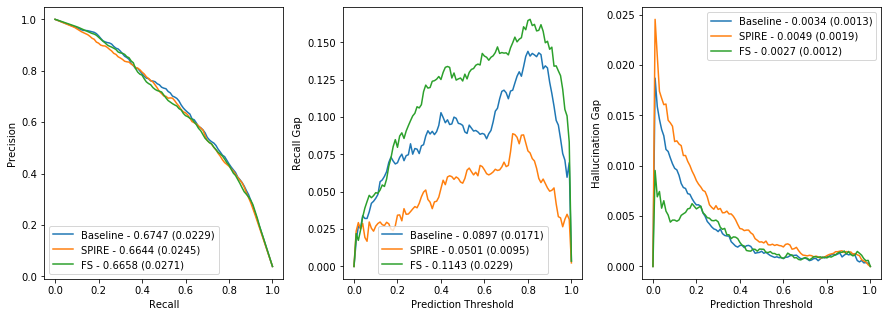

hair+drier-person


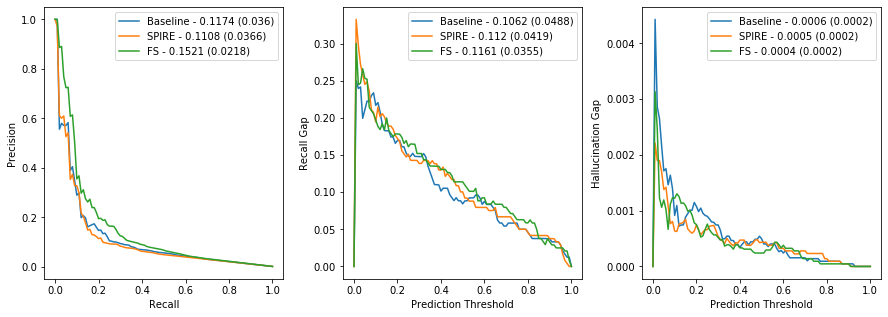

hot+dog-person


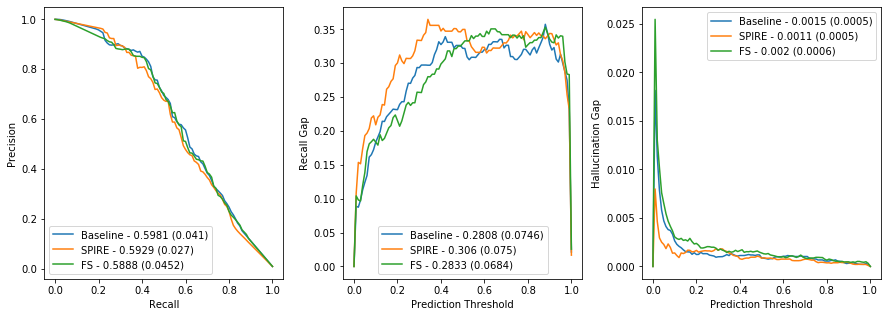

knife-person


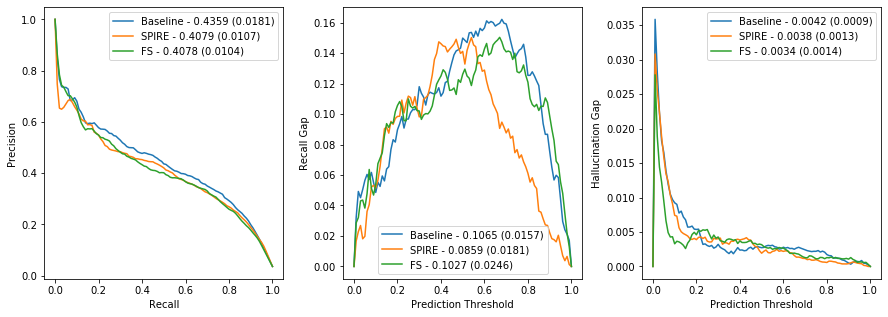

knife-dining+table


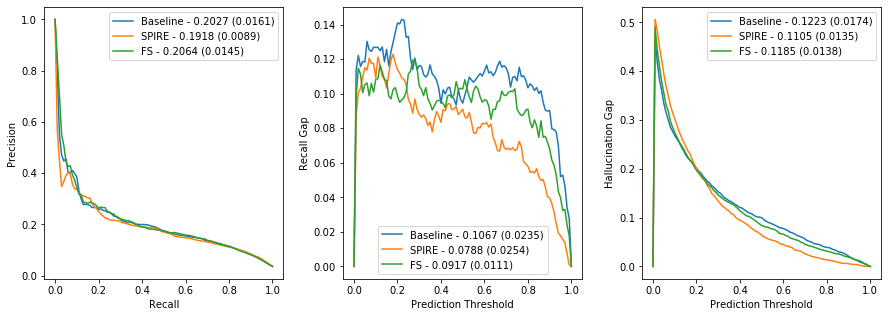

tennis+racket-person


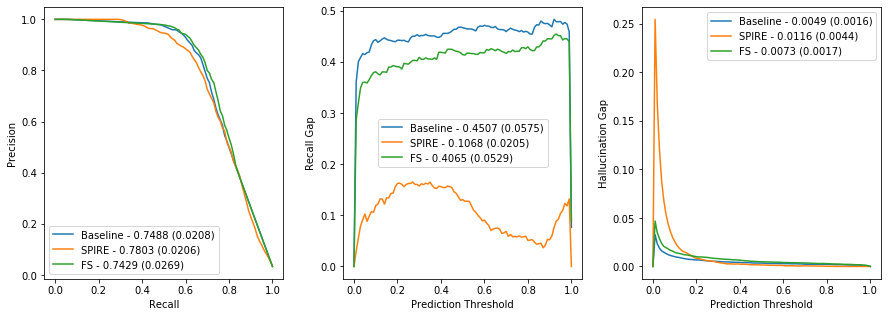

fork-dining+table


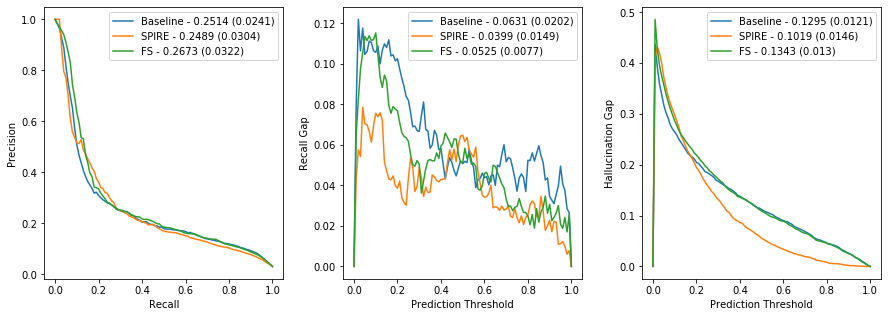

frisbee-person


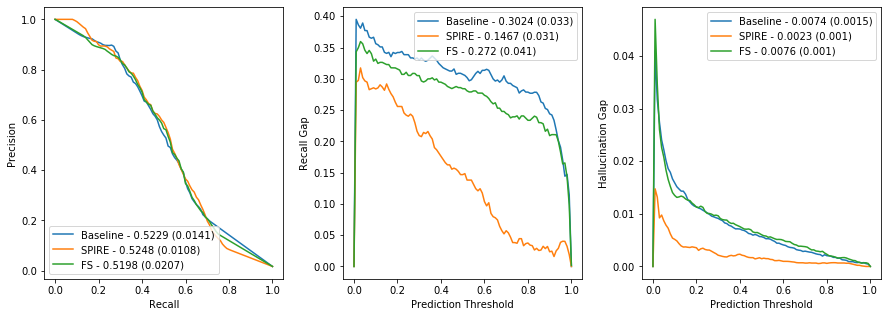

frisbee-dog


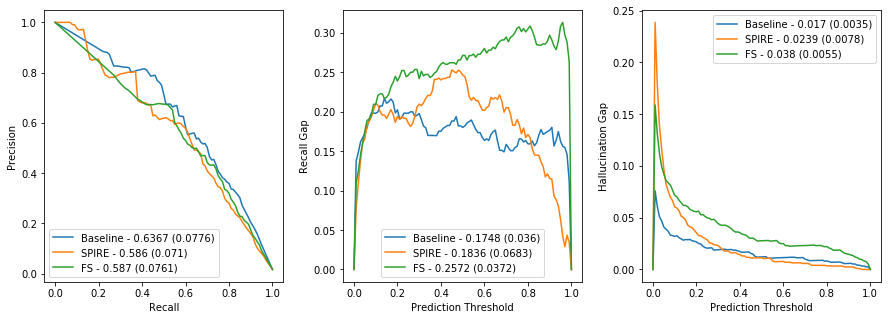

spoon-dining+table


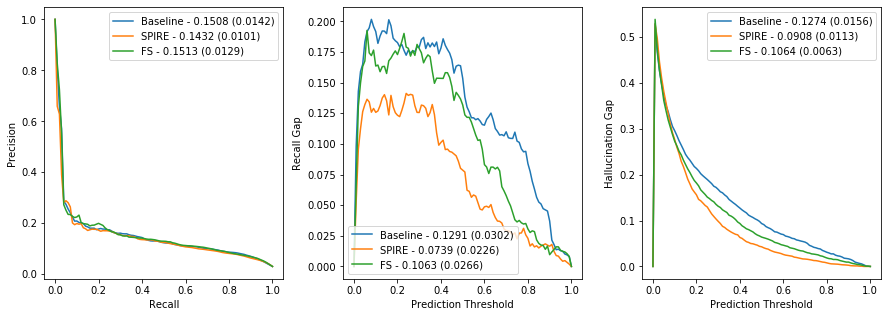

skateboard-person


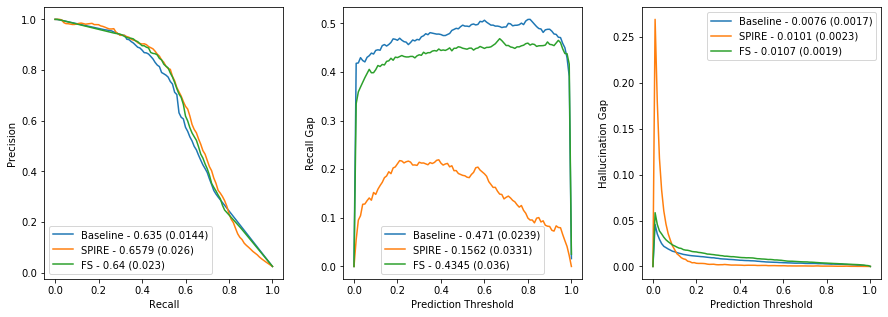

baseball+glove-person


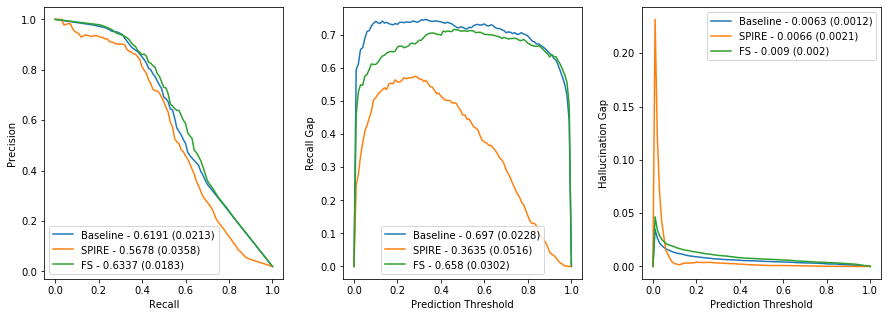

baseball+bat-person


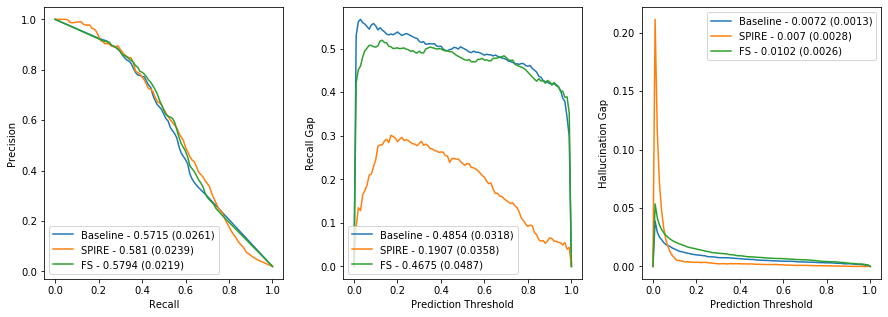

bird-sheep


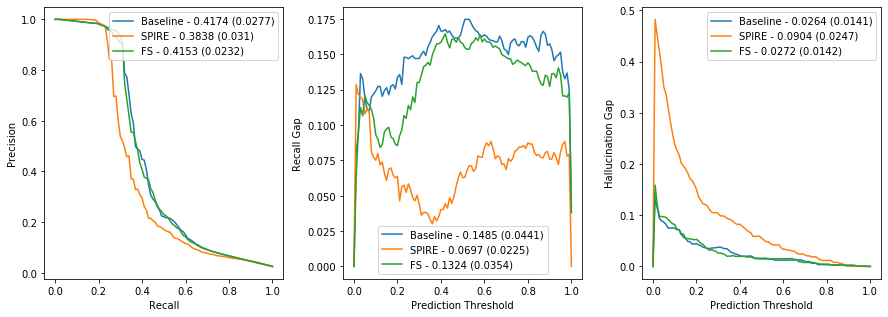

snowboard-person


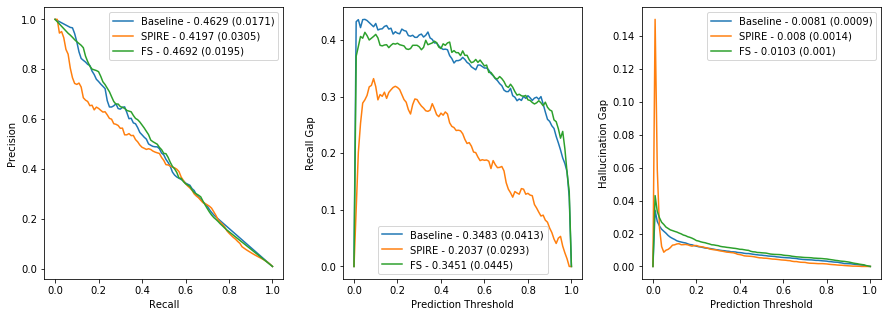

bowl-dining+table


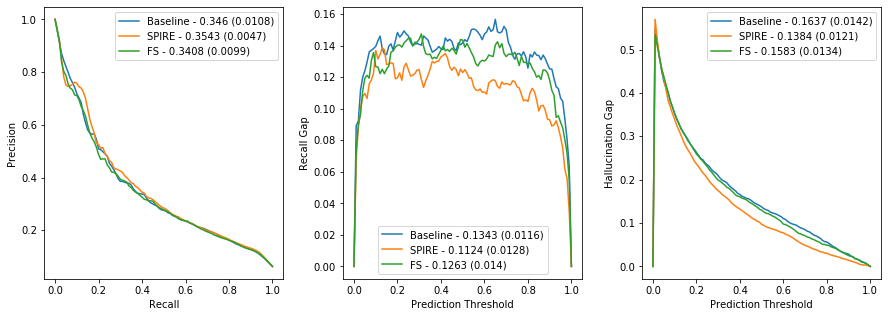

remote-person


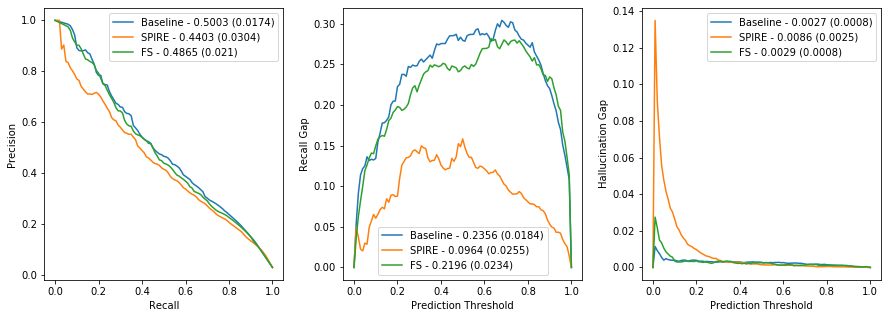

sports+ball-person


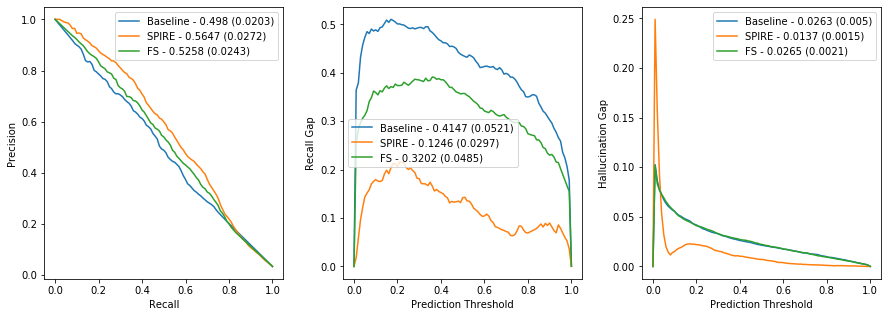

skis-person


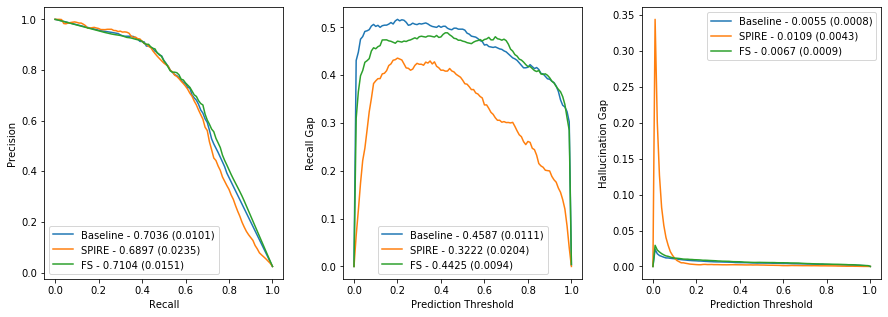

toothbrush-person


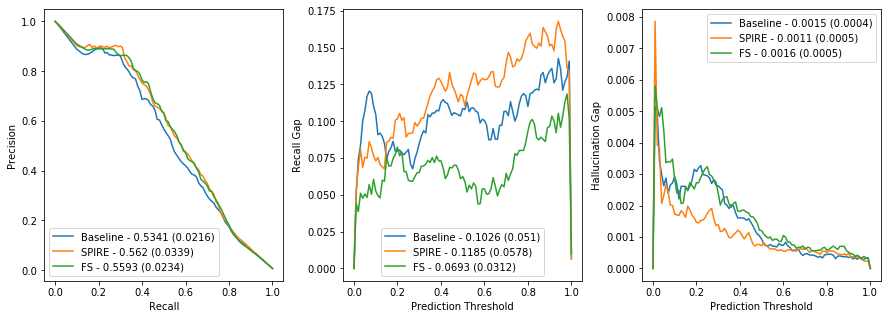

In [4]:
with open('./0-FindPairs/Pairs.json', 'r') as f:
    pairs = json.load(f)

data = {}
for mode in modes:
    data[mode] = {'ap': [], 'r-gap': [], 'h-gap': []} 

for pair in pairs:
    print(pair)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.subplots_adjust(hspace = 0.25, wspace = 0.25)
    
    for mode in modes:

        values = {'ap': [], 'r-gap': [], 'h-gap': []} 
        curves = {'ap': [], 'r-gap': [], 'h-gap': []} 
        for trial in trials:

            with open('./2-Models/Models/{}/trial{}/predictions.pkl'.format(mode, trial), 'rb') as f:
                preds = pickle.load(f)

            p, r, r_gap, h_gap, ts = get_curves(pair, preds)
            
            values['ap'].append(auc(r, p))
            values['r-gap'].append(auc(ts, r_gap))
            values['h-gap'].append(auc(ts, h_gap))
            
            curves['ap'].append(interpolate(r, p, ts))
            curves['r-gap'].append(r_gap)
            curves['h-gap'].append(h_gap)

        values_avg = {}
        values_std = {}
        curves_avg = {}
        for name in values:
            values_avg[name] = np.round(np.mean(values[name]), 4)
            data[mode][name].append(values_avg[name])
            values_std[name] = np.round(np.std(values[name]), 4)
            curves_avg[name] = average_same_x(ts, curves[name])
        
        ax1.plot(ts, curves_avg['ap'], label = '{} - {} ({})'.format(modes[mode], values_avg['ap'], values_std['ap']))
        ax1.set_xlabel('Recall')
        ax1.set_ylabel('Precision')
        ax1.legend()
        
        ax2.plot(ts, curves_avg['r-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['r-gap'], values_std['r-gap']))
        ax2.set_xlabel('Prediction Threshold')
        ax2.set_ylabel('Recall Gap')
        ax2.legend()
        
        ax3.plot(ts, curves_avg['h-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['h-gap'], values_std['h-gap']))
        ax3.set_xlabel('Prediction Threshold')
        ax3.set_ylabel('Hallucination Gap')
        ax3.legend()
        
    plt.show()
    plt.close()


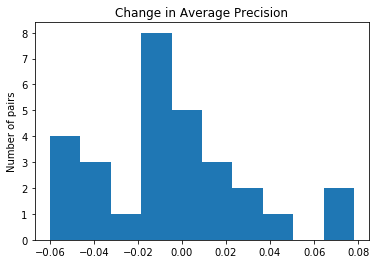

Mean -0.0042
Median -0.0066


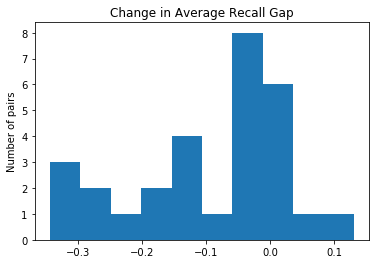

Mean -0.0949
Median -0.0524


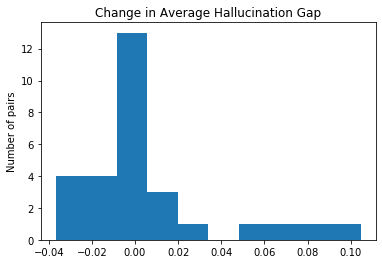

Mean 0.0059
Median -0.0002


In [5]:
corrected = 'SPIRE'
#corrected = 'fs-tune-pbase'
baseline = 'baseline-transfer-ptune'

configs = [('ap', 'Average Precision'), ('r-gap', 'Average Recall Gap'), ('h-gap', 'Average Hallucination Gap')]
for config in configs:
    diffs = np.array(data[corrected][config[0]]) - np.array(data[baseline][config[0]])

    plt.hist(diffs)
    plt.title('Change in {}'.format(config[1]))
    plt.ylabel('Number of pairs')
    plt.show()
    plt.close()
    print('Mean',  np.round(np.mean(diffs), 4))
    print('Median', np.round(np.median(diffs), 4))